# Sample HackerRank Coding Exercise
- https://www.hackerrank.com/contests/intro-to-statistics/challenges/temperature-predictions/problem
- Take care with 2-D: you may need to use the correlation in the variables to improve the fit!

In [265]:
%matplotlib inline
from IPython.core.display import display, HTML 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas_profiling
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
plt.rc("font", size=14)

/anaconda3/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/anaconda3/lib/python3.6/site-packag

In [266]:
import os
import calendar
import collections
from collections import defaultdict, OrderedDict

from scipy.stats import linregress

from datetime import datetime
from dateutil.relativedelta import *
import itertools
from dateutil import parser

import pandas as pd
pd.set_option('display.max_columns', 100)

import numpy as np
import scipy
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import sympy
import requests
from bs4 import BeautifulSoup
from scipy.stats import mode
from scipy import interp

from sklearn import linear_model
from sklearn import preprocessing, linear_model, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline, FeatureUnion

In [269]:
df = pd.read_clipboard(header = 0)
display(df)

,yyyy,month,tmax,tmin
0,1908,January,5.0,-1.4
1,1908,February,7.3,1.9
2,1908,March,6.2,0.3
3,1908,April,Missing_1,2.1
4,1908,May,Missing_2,7.7
5,1908,June,17.7,8.7
6,1908,July,Missing_3,11.0
7,1908,August,17.5,9.7
8,1908,September,16.3,8.4
9,1908,October,14.6,8.0


In [329]:
# use the full set from HackerRank
df = df_hacker_full

In [361]:
pd.to_numeric(df_answer)

ValueError: Unable to parse string "..." at position 30

In [334]:
df_answer = pd.read_clipboard(header=None) #[1]
display(df_answer)

/anaconda3/lib/python3.6/site-packages/pandas/io/clipboards.py:63: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return read_table(StringIO(text), sep=sep, **kwargs)


0      8.6
1     15.8
2     18.9
3      0.0
4      7.0
5      2.2
6      6.0
7      1.8
8     12.5
9      4.8
10     1.3
11     9.0
12    14.9
13    16.7
14     3.8
15     7.2
16    10.1
17     7.3
18     8.5
19    12.5
20     3.5
21    17.5
22    11.2
23     6.6
24     0.3
25    18.4
26    15.8
27    12.5
28    -0.9
29    18.7
      ... 
31     6.4
32     4.0
33     6.1
34    10.2
35     7.1
36     8.3
37    21.4
38     3.7
39    -0.2
40     9.4
41    11.6
42     2.7
43     9.8
44    20.3
45     3.0
46    11.5
47     6.8
48     3.2
49    -0.8
50     7.4
51     4.8
52    10.9
53    12.4
54    -3.4
55     5.7
56     5.8
57     2.4
58    -2.5
59     3.8
60    10.9
Name: 1, Length: 61, dtype: object

## Treat missing values in a standard way

In [342]:
df2 = df.copy(deep = True)
df2[["tmax_clean", "tmin_clean"]] = df[["tmax", "tmin"]].replace(to_replace= r'(?i)missing', value=np.nan, regex= True)

df2["tmax_clean"] = df2["tmax_clean"].apply(pd.to_numeric)
df2["tmin_clean"] = df2["tmin_clean"].apply(pd.to_numeric)
df2.head(5)

,yyyy,month,tmax,tmin,tmax_clean,tmin_clean
0,1908,January,5.0,-1.4,5.0,-1.4
1,1908,February,7.3,1.9,7.3,1.9
2,1908,March,6.2,0.3,6.2,0.3
3,1908,April,Missing_1,2.1,NaN,2.1
4,1908,May,Missing_2,7.7,NaN,7.7


### Convert to datetime index

In [345]:
d = dict(zip(pd.date_range('2000-01-01', freq='M', periods=12).strftime('%B'), range(1,13)))
df2["month_number"] = df2["month"].replace(d)

df2["yyyy"] = df2["yyyy"].map(str)
df2["date_time"] = df2['month'] + "-" + df2["yyyy"]
df2["date_time"]  = df2["date_time"].apply(lambda x: pd.to_datetime(x,format = '%B-%Y'))
df2.set_index("date_time", inplace = True)


pandas_profiling.ProfileReport(df2[["tmax_clean", "tmin_clean", "month_number"]])

Number of variables,4
Number of observations,443
Total Missing (%),2.8%
Total size in memory,13.9 KiB
Average record size in memory,32.2 B
Numeric,2
Categorical,0
Boolean,0
Date,1
Text (Unique),0
Rejected,1


# Correlation among the Temperature Min and Max Values

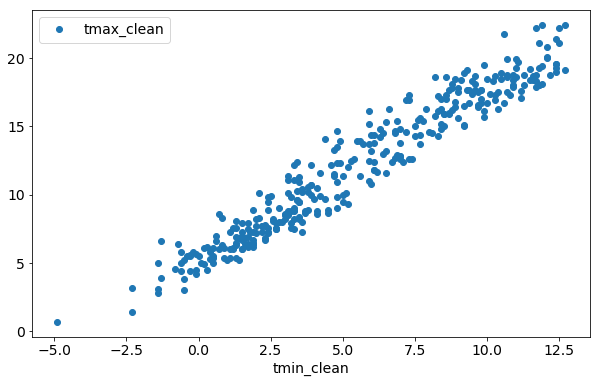

In [214]:
df2.plot(x='tmin_clean', y='tmax_clean', style='o')

# Perform Linear interpolation  [tmin,tmax]
- leverage the correlation in the data

1.2348660793915442 5.325422879220441


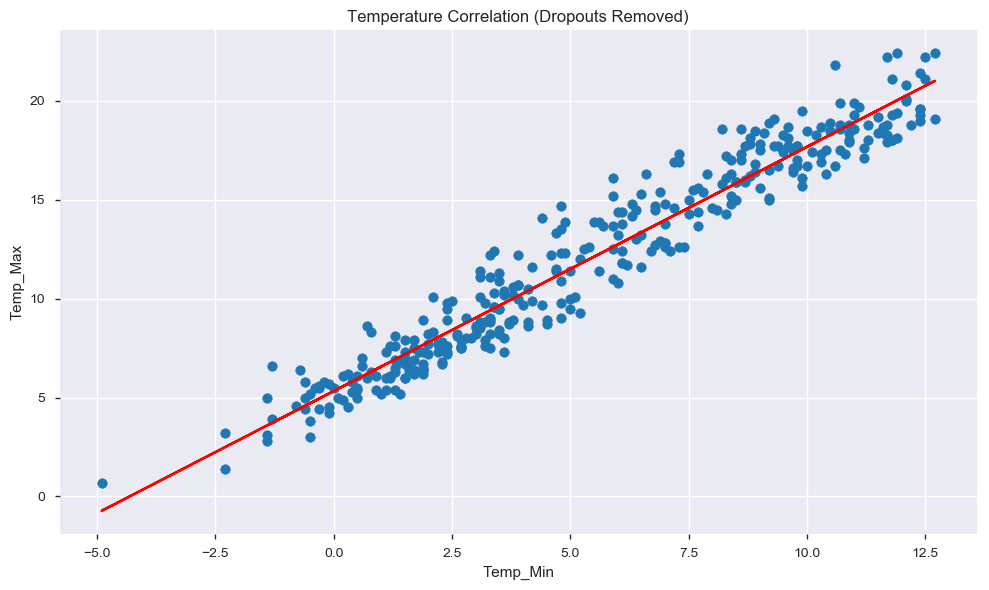

OrderedDict([('Missing_1', 7.918641645942683), ('Missing_2', 14.833891690535332), ('Missing_3', 18.908949752527427), ('Missing_4', 0.3843146465027182), ('Missing_5', 7.177721998307757), ('Missing_6', 3.0566692079188105), ('Missing_7', 7.267652153180534), ('Missing_8', 0.3843146465027182), ('Missing_9', 13.179224364797951), ('Missing_10', 5.448909487159596), ('Missing_11', 1.0321581765429828), ('Missing_12', 9.647454157090845), ('Missing_13', 13.475539003204634), ('Missing_14', 17.55059706519673), ('Missing_15', 2.4088256778785464), ('Missing_16', 6.807262174490294), ('Missing_17', 10.668830685891924), ('Missing_18', 5.971965093100002), ('Missing_19', 8.536074685638456), ('Missing_20', 14.21645865083956), ('Missing_21', 3.0566692079188105), ('Missing_22', 18.04454349695335), ('Missing_23', 11.623239884117316), ('Missing_24', 6.807262174490294), ('Missing_25', -0.7494115310677449), ('Missing_26', 19.032436360466583), ('Missing_27', 16.315730985805185), ('Missing_28', 12.85810596350886), 

TypeError: unsupported operand type(s) for -: 'str' and 'list'

In [365]:
x = df2.dropna(how='any',subset= ["tmin_clean", "tmax_clean"]).tmin_clean.values
y = df2.dropna(how='any',subset= ["tmin_clean", "tmax_clean"]).tmax_clean.values

stats = linregress(x, y)

m = stats.slope
b = stats.intercept
print(m,b)

fig2, ax2 = plt.subplots(figsize=(10,6))
plt.scatter(x, y)
plt.plot(x, m * x + b, color="red")   # I've added a color argument here

ax2.set_title("Temperature Correlation (Dropouts Removed)")
ax2.set_ylabel("Temp_Max")
ax2.set_xlabel("Temp_Min")
plt.tight_layout()
plt.savefig("TempCorrelation.png")
plt.show()

my_dict = OrderedDict()
for idx, row in df2.iterrows():
    if (("Missing" in row["tmin"]) & (not "Missing" in row["tmax"])):
        my_dict[row["tmin"]] = 1/float(m)*(row["tmax_clean"] - b)
    if (("Missing" in row["tmax"]) & (not "Missing" in row["tmin"])):
        my_dict[row["tmax"]] = m * row["tmin_clean"] + b
        
print(my_dict)
my_list = list(my_dict.values())
print()
for elem in my_list:
    print(elem)
    
df_answer["my_answer"] = my_list
df_answer["delta"] = df_answer[0] - df_answer["my_answer"]

df_answer

## SciKit Learn Fit based on [month_number, tmin, tmax] ignoring the year.
 - Use data without Nan's as the training set
 - Use the tmin = nan as those to predict based on [month_number, tmax]
 - Use the tmax = nan as those to predict based on [month_number, tmin]

In [347]:
from sklearn.linear_model import LinearRegression
df_train = df2.dropna(how='any',subset= ["tmin_clean", "tmax_clean"])
df_train = df_train[["month_number", "tmax_clean", "tmin_clean"]]

df_test = df2[df2[["tmin_clean", "tmax_clean"]].isnull().any(axis=1)]
df_test = df_test[["month_number", "tmax_clean", "tmin_clean"]]

X_train = df_train[["month_number", "tmax_clean"]].values
Y_train = df_train["tmin_clean"].values
X_mintest = df_test[df_test["tmin_clean"].isnull()][["month_number", "tmax_clean"]].values

reg = LinearRegression()
model = reg.fit(X_train, Y_train)
tmin_predict = model.predict(X_mintest) 


X_train = df_train[["month_number", "tmin_clean"]].values
Y_train = df_train["tmax_clean"].values
X_maxtest = df_test[df_test["tmax_clean"].isnull()][["month_number", "tmin_clean"]].values

reg = LinearRegression()
model = reg.fit(X_train, Y_train)

tmax_predict = model.predict(X_maxtest) 

df_final = df2.copy(deep = True)
df_final.loc[df_final["tmax_clean"].isnull(),"tmax_hat"] = tmax_predict
df_final.loc[df_final["tmin_clean"].isnull(),"tmin_hat"] = tmin_predict

my_dict = OrderedDict()
for idx, row in df_final.iterrows():
    if "Missing" in row["tmin"]:
        my_dict[row["tmin"]] = row["tmin_hat"]
    if "Missing" in row["tmax"]:
        my_dict[row["tmax"]] = row["tmax_hat"]

my_list = list(my_dict.values())
print()
for elem in my_list:
    print(elem)

OrderedDict([('Missing_1', 8.140726431341506), ('Missing_2', 15.100011114694642), ('Missing_3', 19.023602233812326), ('Missing_4', 1.398957618381834), ('Missing_5', 7.633140536083213), ('Missing_6', 2.8502504926110115), ('Missing_7', 6.946456570912019), ('Missing_8', 0.16902637799948117), ('Missing_9', 12.718402013708408), ('Missing_10', 5.987641756511352), ('Missing_11', 0.8766201883915326), ('Missing_12', 10.037751587623829), ('Missing_13', 13.708305282751928), ('Missing_14', 17.757659590224844), ('Missing_15', 3.148964060713613), ('Missing_16', 7.253584400098837), ('Missing_17', 10.409747230846627), ('Missing_18', 6.313952466734868), ('Missing_19', 8.899083179670697), ('Missing_20', 13.83860161294453), ('Missing_21', 3.7447459401618133), ('Missing_22', 18.137971249848782), ('Missing_23', 11.18170866105389), ('Missing_24', 5.995952516546531), ('Missing_25', -0.6499680491471702), ('Missing_26', 19.150120945807117), ('Missing_27', 16.115182905211228), ('Missing_28', 12.446895781001814)

In [360]:
(df_answer.dtype)

dtype('O')

In [349]:
df_answer["sckit_answer"] = my_list
df_answer["delta"] = df_answer[0] - df_answer["sckit_answer"]
df_answer

TypeError: unsupported operand type(s) for -: 'str' and 'list'

# Apply Pandas built in interpolation methods
- https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.interpolate.html

Types of missing data:
- if upsampling is required:
      upsampled = df.series.resample('D')
- if the dates are missing
      df = df.reindex(pd.date_range("2011-01-01", "2011-10-31"), fill_value="NaN")
- if the data contains duplicates:
      df.drop_duplicates(keep = 'first', inplace = True)

- forward fill copies values forward.  Limit will impact how big a gap you will fill
https://chrisalbon.com/machine_learning/preprocessing_dates_and_times/handling_missing_values_in_time_series/
https://chrisalbon.com/python/data_wrangling/pandas_missing_data/
      
- methods: {‘linear’, ‘time’, ‘index’, ‘values’, ‘nearest’, ‘zero’, 'slinear’, ‘quadratic’, ‘cubic’, ‘barycentric’,
            ‘krogh’, ‘polynomial’, ‘spline’, ‘piecewise_polynomial’, ‘from_derivatives’, ‘pchip’, ‘akima’}
            
      - method='quadratic'  if you are dealing with a time series that is growing at an increasing rate.
      - method='pchip' if you have values approximating a cumulative distribution function. 
      - method='akima': to fill missing values with goal of smooth plotting.

In [192]:
df_interp = df2.copy(deep = True)

df_interp["tmin_hat"] = df_interp["tmin_clean"].interpolate(axis=0, method='time',\
                         limit=None, inplace=False, limit_direction='forward', limit_area=None, downcast=None).ffill().bfill()
df_interp["tmax_hat"] = df_interp["tmax_clean"].interpolate(axis=0, method='time',\
                        limit=None, inplace=False, limit_direction='forward', limit_area=None, downcast=None).ffill().bfill()
df_interp[["tmin", "tmin_clean", "tmin_hat", "tmax", "tmax_clean", "tmax_hat"]].head(7)


,tmin,tmin_clean,tmin_hat,tmax,tmax_clean,tmax_hat
date_time,,,,,,
1908-01-01,-1.4,-1.4,-1.4,5.0,5.0,5.000000e+00
1908-02-01,1.9,1.9,1.9,7.3,7.3,7.300000e+00
1908-03-01,0.3,0.3,0.3,6.2,6.2,6.200000e+00
1908-04-01,2.1,2.1,2.1,Missing_1,NaN,9.657792e+12
1908-05-01,7.7,7.7,7.7,Missing_2,NaN,7.358381e+13
1908-06-01,8.7,8.7,8.7,17.7,17.7,1.770000e+01
1908-07-01,11.0,11.0,11.0,Missing_3,NaN,3.083896e+11


In [198]:
df_interp[["tmax_hat", "tmin_hat"]] = df_interp[["tmax_clean", "tmin_clean"]].interpolate(method='polynomial', order=2).ffill().bfill()
df_interp[["tmin", "tmin_clean", "tmin_hat", "tmax", "tmax_clean", "tmax_hat"]].head(7)

,tmin,tmin_clean,tmin_hat,tmax,tmax_clean,tmax_hat
date_time,,,,,,
1908-01-01,-1.4,-1.4,-1.4,5.0,5.0,5.000000
1908-02-01,1.9,1.9,1.9,7.3,7.3,7.300000
1908-03-01,0.3,0.3,0.3,6.2,6.2,6.200000
1908-04-01,2.1,2.1,2.1,Missing_1,NaN,8.381624
1908-05-01,7.7,7.7,7.7,Missing_2,NaN,13.975350
1908-06-01,8.7,8.7,8.7,17.7,17.7,17.700000
1908-07-01,11.0,11.0,11.0,Missing_3,NaN,18.423150


In [ ]:
df_interp = df2.copy(deep = True)

df_interp["tmin_hat"] = df_interp["tmin_clean"].interpolate(axis=0, method='time',\
                         limit=None, inplace=False, limit_direction='forward', limit_area=None, downcast=None).ffill().bfill()
df_interp["tmax_hat"] = df_interp["tmax_clean"].interpolate(axis=0, method='time',\
                        limit=None, inplace=False, limit_direction='forward', limit_area=None, downcast=None).ffill().bfill()
df_interp[["tmin", "tmin_clean", "tmin_hat", "tmax", "tmax_clean", "tmax_hat"]].head(7)


## Impose constraints
 -  1908 <=time <= 2013
 -  -75 <= Tmax/Tmin <= 75

In [199]:
df_interp["temp_constraint_v"] = df_interp["tmax_hat"]/df_interp["tmin_hat"]
df_interp[abs(df_interp["temp_constraint_v"]) > 75]

,yyyy,month,tmax,tmin,tmax_clean,tmin_clean,tmin_hat,tmax_hat,temp_constraint_v
date_time,,,,,,,,,
1919-03-01,1919,March,5.4,Missing_38,5.4,NaN,0.01584,5.4,340.900314
1931-01-01,1931,January,5.5,0.0,5.5,0.0,0.00000,5.5,inf


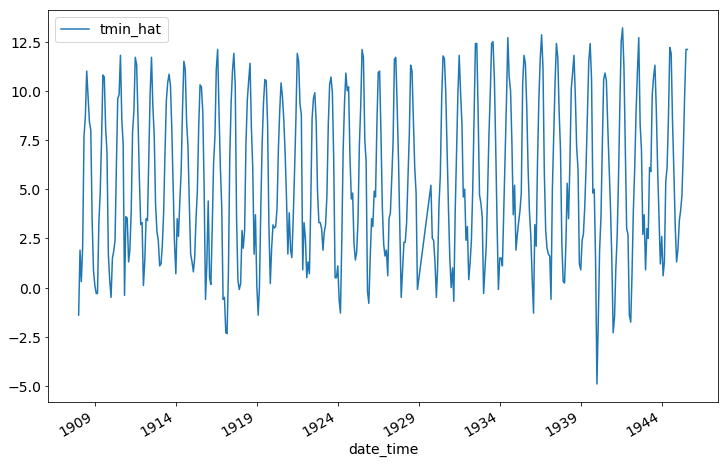

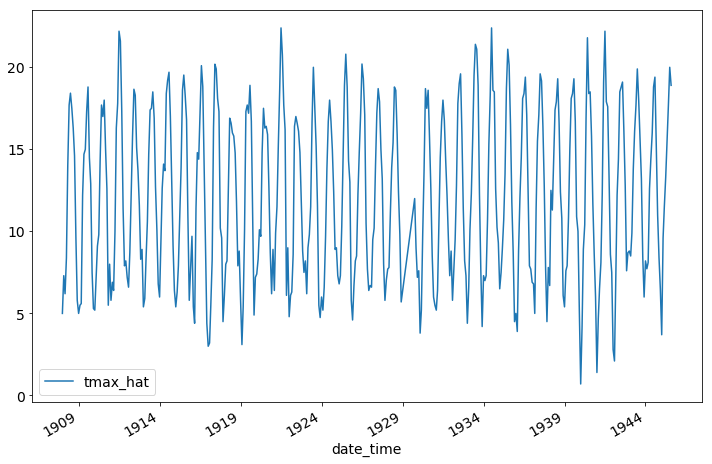

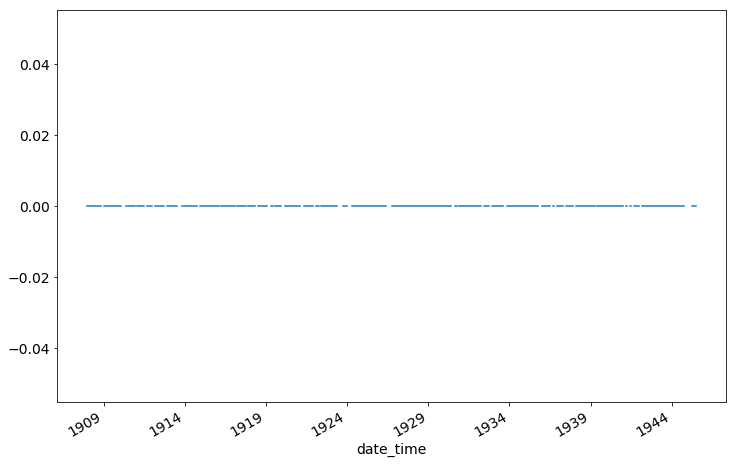

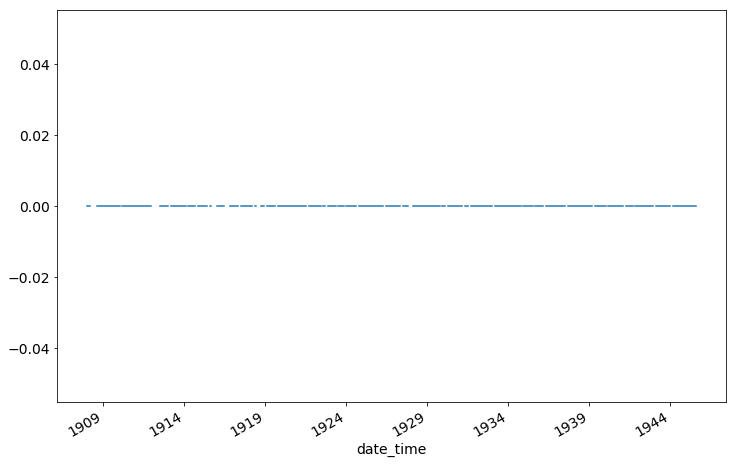

In [200]:
df_interp[['tmin', 'tmin_hat']].plot(figsize=(12, 8))
plt.show()

df_interp[['tmax', 'tmax_hat']].plot(figsize=(12, 8))
plt.show()

df_interp["min_resid"] = df_interp['tmin_clean'] - df_interp['tmin_hat']
df_interp["min_resid"].plot(figsize=(12, 8))
plt.show()

df_interp["max_resid"] = df_interp['tmax_clean'] - df_interp['tmax_hat']
df_interp["max_resid"].plot(figsize=(12, 8))
plt.show()

In [201]:
# Print the missing values
df_final = df_interp[df_interp['tmin'].str.startswith("Missing") | df_interp['tmax'].str.startswith("Missing")]
df_final

,yyyy,month,tmax,tmin,tmax_clean,tmin_clean,tmin_hat,tmax_hat,temp_constraint_v,min_resid,max_resid
date_time,,,,,,,,,,,
1908-04-01,1908,April,Missing_1,2.1,NaN,2.1,2.100000,8.381624,3.991250,0.0,NaN
1908-05-01,1908,May,Missing_2,7.7,NaN,7.7,7.700000,13.975350,1.814980,0.0,NaN
1908-07-01,1908,July,Missing_3,11.0,NaN,11.0,11.000000,18.423150,1.674832,0.0,NaN
1908-12-01,1908,December,5.8,Missing_4,5.8,NaN,0.861983,5.800000,6.728671,NaN,0.0
1910-02-01,1910,February,Missing_5,1.5,NaN,1.5,1.500000,7.329750,4.886500,0.0,NaN
1910-03-01,1910,March,9.1,Missing_6,9.1,NaN,1.831065,9.100000,4.969784,NaN,0.0
1910-05-01,1910,May,14.3,Missing_7,14.3,NaN,6.158930,14.300000,2.321832,NaN,0.0
1911-01-01,1911,January,5.8,Missing_8,5.8,NaN,3.518915,5.800000,1.648236,NaN,0.0
1911-08-01,1911,August,21.6,Missing_9,21.6,NaN,11.323138,21.600000,1.907598,NaN,0.0


In [202]:
my_dict = OrderedDict()
for idx, row in df_final.iterrows():
    if "Missing" in row["tmin"]:
        my_dict[row["tmin"]] = row["tmin_hat"]
    if "Missing" in row["tmax"]:
        my_dict[row["tmax"]] = row["tmax_hat"]
#print(my_dict)
my_list = list(my_dict.values())
print()
for elem in my_list:
    print(elem)


8.381624067815403
13.975349514963721
18.423150275269492
0.86198297335041
7.3297495121308796
1.8310653998341
6.158930129933395
3.5189145295449022
11.323138481834889
7.2084555827174555
1.3706255111190282
8.725386572542844
15.786825449530209
18.66262353044206
2.8423667419847276
5.910605938289028
10.840971991188336
8.14194467418002
12.621326559259112
13.080162171904107
4.282895000077225
19.526802890410693
10.964352986425277
7.755246076376266
0.1569785613822936
17.11756595937282
18.818463151969148
14.04439080725485
-2.344223625050941
20.188749237400117
0.3682720656421487
12.669831048346508
9.53336818763174
16.001911901786592
15.80733380653308
14.7825230920491
5.823310771277718
0.01584040781646001
4.054916717321723
10.573054478445645
16.7053273609195
3.1859734563473867
3.0244103443145067
1.521231619041324
3.5315893517959713
20.743113873478478
2.4861165651963866
4.184509127570537
16.588656925108882
11.926816644909989
16.682696860483677
10.30840938753775
9.885903030365718
4.749226033000501
-0

In [203]:
df_answer["my_answer"] = my_list
df_answer["delta"] = df_answer[0] - df_answer["my_answer"]
df_answer

,0,my_answer,delta
0,8.6,8.381624,0.218376
1,15.8,13.975350,1.824650
2,18.9,18.423150,0.476850
3,0.0,0.861983,-0.861983
4,7.0,7.329750,-0.329750
5,2.2,1.831065,0.368935
6,6.0,6.158930,-0.158930
7,1.8,3.518915,-1.718915
8,12.5,11.323138,1.176862
9,4.8,7.208456,-2.408456


In [208]:
df2.head(10)

,yyyy,month,tmax,tmin,tmax_clean,tmin_clean
date_time,,,,,,
1908-01-01,1908,January,5.0,-1.4,5.0,-1.4
1908-02-01,1908,February,7.3,1.9,7.3,1.9
1908-03-01,1908,March,6.2,0.3,6.2,0.3
1908-04-01,1908,April,Missing_1,2.1,NaN,2.1
1908-05-01,1908,May,Missing_2,7.7,NaN,7.7
1908-06-01,1908,June,17.7,8.7,17.7,8.7
1908-07-01,1908,July,Missing_3,11.0,NaN,11.0
1908-08-01,1908,August,17.5,9.7,17.5,9.7
1908-09-01,1908,September,16.3,8.4,16.3,8.4


In [362]:
df_interp

,yyyy,month,tmax,tmin,tmax_clean,tmin_clean,tmin_hat,tmax_hat,temp_constraint_v,min_resid,max_resid
date_time,,,,,,,,,,,
1908-01-01,1908,January,5.0,-1.4,5.0,-1.4,-1.400000,5.000000,-3.571429,0.0,0.0
1908-02-01,1908,February,7.3,1.9,7.3,1.9,1.900000,7.300000,3.842105,0.0,0.0
1908-03-01,1908,March,6.2,0.3,6.2,0.3,0.300000,6.200000,20.666667,0.0,0.0
1908-04-01,1908,April,Missing_1,2.1,NaN,2.1,2.100000,8.381624,3.991250,0.0,NaN
1908-05-01,1908,May,Missing_2,7.7,NaN,7.7,7.700000,13.975350,1.814980,0.0,NaN
1908-06-01,1908,June,17.7,8.7,17.7,8.7,8.700000,17.700000,2.034483,0.0,0.0
1908-07-01,1908,July,Missing_3,11.0,NaN,11.0,11.000000,18.423150,1.674832,0.0,NaN
1908-08-01,1908,August,17.5,9.7,17.5,9.7,9.700000,17.500000,1.804124,0.0,0.0
1908-09-01,1908,September,16.3,8.4,16.3,8.4,8.400000,16.300000,1.940476,0.0,0.0


In [328]:
df_hacker_full = df_interp[["yyyy", "month", "tmax", "tmin"]].reset_index()
df_hacker_full.drop("date_time", inplace = True, axis = 1)
df_hacker_full

,yyyy,month,tmax,tmin
0,1908,January,5.0,-1.4
1,1908,February,7.3,1.9
2,1908,March,6.2,0.3
3,1908,April,Missing_1,2.1
4,1908,May,Missing_2,7.7
5,1908,June,17.7,8.7
6,1908,July,Missing_3,11.0
7,1908,August,17.5,9.7
8,1908,September,16.3,8.4
9,1908,October,14.6,8.0


In [332]:
df_answer

,0
0,df_hacker_full
